# Level Break Out

### Load the data

In [5]:
import pandas as pd
import pandas_ta as ta
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats

df = pd.read_csv("EURUSD_Candlestick_1_Hour_BID_04.05.2003-15.04.2023.csv")
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)

df['EMA'] = ta.ema(df.close, length=150)
df.tail()

df=df[0:10000]

### Trend detection

In [6]:
EMAsignal = [0]*len(df)
backcandles = 15

for row in range(backcandles, len(df)):
    upt = 1
    dnt = 1
    for i in range(row-backcandles, row+1):
        if max(df.open[i], df.close[i])>=df.EMA[i]:
            dnt=0
        if min(df.open[i], df.close[i])<=df.EMA[i]:
            upt=0
    if upt==1 and dnt==1:
        EMAsignal[row]=3
    elif upt==1:
        EMAsignal[row]=2
    elif dnt==1:
        EMAsignal[row]=1

df['EMASignal'] = EMAsignal

In [7]:
def isPivot(candle, window):
    """
    function that detects if a candle is a pivot/fractal point
    args: candle index, window before and after candle to test if pivot
    returns: 1 if pivot high, 2 if pivot low, 3 if both and 0 default
    """
    if candle-window < 0 or candle+window >= len(df):
        return 0
    
    pivotHigh = 1
    pivotLow = 2
    for i in range(candle-window, candle+window+1):
        if df.iloc[candle].low > df.iloc[i].low:
            pivotLow=0
        if df.iloc[candle].high < df.iloc[i].high:
            pivotHigh=0
    if (pivotHigh and pivotLow):
        return 3
    elif pivotHigh:
        return pivotHigh
    elif pivotLow:
        return pivotLow
    else:
        return 0

In [8]:
# Pivot window 
window=10
df['isPivot'] = df.apply(lambda x: isPivot(x.name,window), axis=1)

In [9]:
def pointpos(x):
    if x['isPivot']==2:
        return x['low']-1e-3
    elif x['isPivot']==1:
        return x['high']+1e-3
    else:
        return np.nan
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

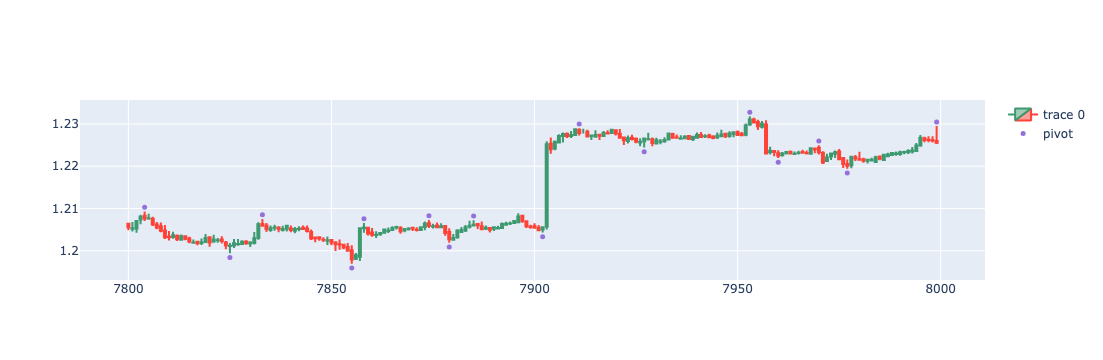

In [18]:
dfpl = df[7800:8000]
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [12]:
# detect uptrend/downtrend (2/1) breakout 
def detect_structure(candle, backcandles, window):
    """
    Attention! window should always be greater than the pivot window! to avoid look ahead bias
    """
    if (candle <= (backcandles+window)) or (candle+window+1 >= len(df)):
        return 0
    
    localdf = df.iloc[candle-backcandles-window:candle-window] #window must be greater than pivot window to avoid look ahead bias
    highs = localdf[localdf['isPivot'] == 1].high.tail(3).values
    lows = localdf[localdf['isPivot'] == 2].low.tail(3).values
    levelbreak = 0
    zone_width = 0.001

    # 3 low supported levels must exist and they need to be close enough
    if len(lows)==3:
        support_condition = True
        mean_low = lows.mean()
        for low in lows:
            if abs(low-mean_low)>zone_width:
                support_condition = False
                break
        if support_condition and (mean_low - df.loc[candle].close)>zone_width*2:
            levelbreak = 1

    # 3 high resistance levels must be spotted and they need to be close enough
    if len(highs)==3:
        resistance_condition = True
        mean_high = highs.mean()
        for high in highs:
            if abs(high-mean_high)>zone_width:
                resistance_condition = False
                break
        if resistance_condition and (df.loc[candle].close-mean_high)>zone_width*2:
            levelbreak = 2
    return levelbreak

In [11]:
# 40-60 hours, 7 trading hours/day, 6-9 days
#df['pattern_detected'] = df.index.map(lambda x: detect_structure(x, backcandles=40, window=15))
df['pattern_detected'] = df.apply(lambda row: detect_structure(row.name, backcandles=60, window=11), axis=1)

In [15]:
df[df['pattern_detected']==1]

,Gmt time,open,high,low,close,volume,EMA,EMASignal,isPivot,pointpos,pattern_detected
4372,14.01.2004 08:00:00.000,1.27098,1.27132,1.26498,1.26532,3.093520e+07,1.272636,0,0,NaN,1
4373,14.01.2004 09:00:00.000,1.26525,1.26857,1.26498,1.26649,3.064930e+07,1.272555,0,0,NaN,1
4374,14.01.2004 10:00:00.000,1.26675,1.26724,1.26557,1.26604,3.218730e+07,1.272469,0,0,NaN,1
4375,14.01.2004 11:00:00.000,1.26609,1.26820,1.26533,1.26766,3.071660e+07,1.272405,0,0,NaN,1
4376,14.01.2004 12:00:00.000,1.26765,1.26886,1.26686,1.26822,3.255050e+07,1.272350,0,0,NaN,1
4377,14.01.2004 13:00:00.000,1.26803,1.26965,1.26276,1.26458,3.049790e+07,1.272247,0,2,1.26176,1
4378,14.01.2004 14:00:00.000,1.26426,1.26733,1.26385,1.26721,3.064750e+07,1.272180,0,0,NaN,1
4379,14.01.2004 15:00:00.000,1.26696,1.26912,1.26522,1.26818,3.351830e+07,1.272127,0,0,NaN,1
4382,14.01.2004 18:00:00.000,1.27128,1.27188,1.26792,1.26826,1.454526e+08,1.272068,0,0,NaN,1
4383,14.01.2004 19:00:00.000,1.26834,1.26841,1.26603,1.26645,1.050252e+08,1.271993,0,0,NaN,1


In [17]:
df[df['pattern_detected']==2]

,Gmt time,open,high,low,close,volume,EMA,EMASignal,isPivot,pointpos,pattern_detected
4087,29.12.2003 11:00:00.000,1.24800,1.24938,1.24725,1.24884,3.046900e+07,1.241794,2,0,NaN,2
4088,29.12.2003 12:00:00.000,1.24865,1.25058,1.24813,1.24963,3.003030e+07,1.241898,2,1,1.25158,2
4089,29.12.2003 13:00:00.000,1.24968,1.25042,1.24879,1.24919,3.105770e+07,1.241995,2,0,NaN,2
7903,06.08.2004 12:00:00.000,1.20573,1.22591,1.20502,1.22521,3.215400e+07,1.206304,0,0,NaN,2
7904,06.08.2004 13:00:00.000,1.22531,1.22680,1.22296,1.22398,3.152610e+07,1.206538,0,0,NaN,2
7905,06.08.2004 14:00:00.000,1.22420,1.22610,1.22380,1.22578,3.417230e+07,1.206793,0,0,NaN,2
7906,06.08.2004 15:00:00.000,1.22559,1.22754,1.22545,1.22714,3.294610e+07,1.207062,0,0,NaN,2
7907,06.08.2004 16:00:00.000,1.22715,1.22795,1.22560,1.22762,2.952309e+08,1.207335,0,0,NaN,2
7908,06.08.2004 17:00:00.000,1.22768,1.22800,1.22667,1.22710,1.345339e+08,1.207597,0,0,NaN,2
7909,06.08.2004 18:00:00.000,1.22716,1.22835,1.22668,1.22737,1.469386e+08,1.207858,0,0,NaN,2
